In [3]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, mannwhitneyu

# Load data
df = pd.read_csv('confusability_metrics.csv')
df.head()

,short_label,label,instruct,vocab_size,L0,logV,tokens_at_z0.5,tokens_to_lose_0.5_nats,initial_slope,n_eval_points,eval_points
0,Qwen2.5-7B,Qwen/Qwen2.5-7B,False,151643,2.012218,11.929284,1.484017e+07,11520000,1.347227e+07,30,"[(1280000, 2.012218475341797), (2560000, 2.011..."
1,Qwen2.5-7B-Instruct,Qwen/Qwen2.5-7B-Instruct,True,151643,2.108742,11.929284,1.314429e+07,11520000,1.213681e+07,30,"[(1280000, 2.1087424755096436), (2560000, 2.09..."
2,Qwen2.5-0.5B,Qwen/Qwen2.5-0.5B,False,151643,2.675917,11.929284,1.474955e+07,8960000,1.189445e+07,30,"[(1280000, 2.675917148590088), (2560000, 2.683..."
3,Qwen2.5-0.5B-Instruct,Qwen/Qwen2.5-0.5B-Instruct,True,151643,2.769986,11.929284,1.210313e+07,7680000,9.779472e+06,30,"[(1280000, 2.769986391067505), (2560000, 2.783..."
4,Qwen2.5-1.5B,Qwen/Qwen2.5-1.5B,False,151643,2.326171,11.929284,2.105161e+07,12800000,1.683725e+07,30,"[(1280000, 2.3261709213256836), (2560000, 2.32..."


In [6]:
# Extract model size from short_label
def extract_size(label):
    match = re.search(r'(\d+\.?\d*)B', label)
    if match:
        return float(match.group(1))
    if "Mistral-Nemo" in label:
        return 12
    return None

df['model_size_b'] = df['short_label'].apply(extract_size)
df[['short_label', 'model_size_b', 'instruct']].sort_values(by='model_size_b')

,short_label,model_size_b,instruct
2,Qwen2.5-0.5B,0.5,False
3,Qwen2.5-0.5B-Instruct,0.5,True
4,Qwen2.5-1.5B,1.5,False
5,Qwen2.5-1.5B-Instruct,1.5,True
10,Llama-3.2-3B,3.0,False
11,Llama-3.2-3B-Instruct,3.0,True
8,Qwen2.5-3B,3.0,False
9,Qwen2.5-3B-Instruct,3.0,True
16,Mistral-7B-Instruct-v0.3,7.0,True
15,Mistral-7B-v0.3,7.0,False


## 1. Correlation between Model Size and Half-Life

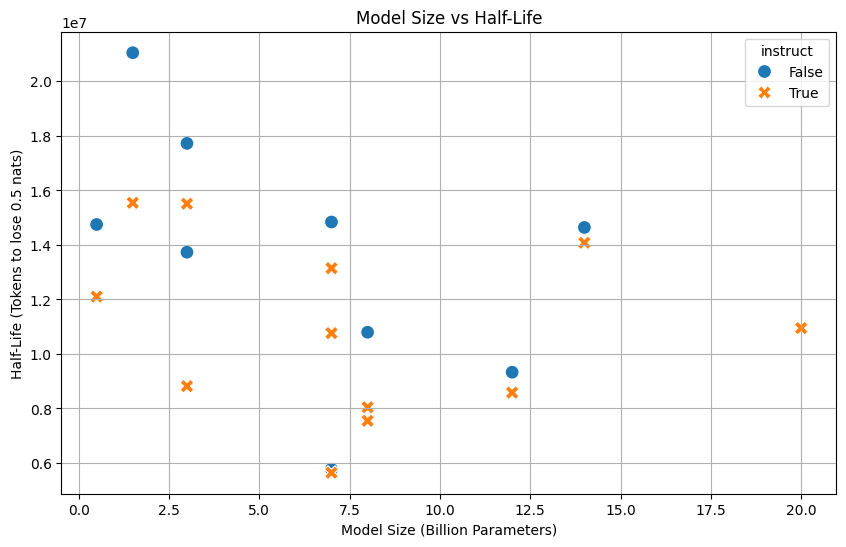

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='model_size_b', y='tokens_at_z0.5', hue='instruct', style='instruct', s=100)
plt.title('Model Size vs Half-Life')
plt.xlabel('Model Size (Billion Parameters)')
plt.ylabel('Half-Life (Tokens to lose 0.5 nats)')
plt.grid(True)
plt.show()

In [8]:
# Calculate correlations
clean_df = df.dropna(subset=['model_size_b', 'tokens_at_z0.5'])

pearson_corr, p_p = pearsonr(clean_df['model_size_b'], clean_df['tokens_at_z0.5'])
spearman_corr, p_s = spearmanr(clean_df['model_size_b'], clean_df['tokens_at_z0.5'])

print(f"Pearson Correlation: {pearson_corr:.3f} (p={p_p:.3f})")
print(f"Spearman Correlation: {spearman_corr:.3f} (p={p_s:.3f})")

Pearson Correlation: -0.340 (p=0.131)
Spearman Correlation: -0.427 (p=0.054)


## 2. Instruct vs Non-Instruct Half-Life

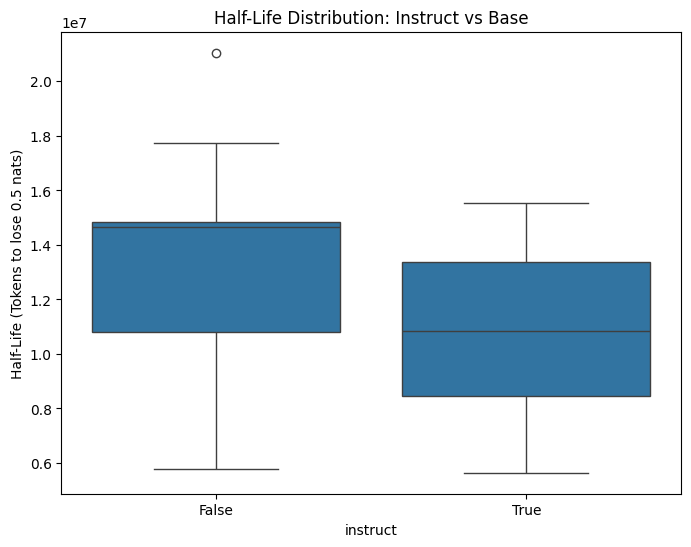

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='instruct', y='tokens_at_z0.5')
plt.title('Half-Life Distribution: Instruct vs Base')
plt.ylabel('Half-Life (Tokens to lose 0.5 nats)')
plt.show()

In [10]:
instruct_vals = df[df['instruct'] == True]['tokens_at_z0.5']
base_vals = df[df['instruct'] == False]['tokens_at_z0.5']

print(f"Instruct Mean: {instruct_vals.mean():,.0f}")
print(f"Base Mean: {base_vals.mean():,.0f}")

t_stat, p_t = ttest_ind(instruct_vals, base_vals)
u_stat, p_u = mannwhitneyu(instruct_vals, base_vals)

print(f"T-test: p={p_t:.3f}")
print(f"Mann-Whitney U: p={p_u:.3f}")

Instruct Mean: 10,893,378
Base Mean: 13,625,796
T-test: p=0.123
Mann-Whitney U: p=0.145
